# Book recommendations system

In [3]:
%%capture
! pip install seaborn

In [4]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from time import time
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import requests
from PIL import Image
import io

import matplotlib.pyplot as plt

sns.set() 

## 1. Exploratory Analysis

In [5]:
df_books = pd.read_csv('./BX-Books.csv', encoding='latin_1', sep=';', escapechar='\\', quotechar='"')
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


Extend books dataset by summaries

In [6]:
# src: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset
df_summaries = pd.read_csv('./Preprocessed_data.csv')
df_summaries.drop_duplicates(subset='isbn', inplace=True)
df_summaries = df_summaries[['isbn', 'Summary', 'Language', 'Category']]
df_summaries.rename(columns={"isbn": "ISBN"}, inplace=True)
print('Number of books without Summary: ', len(df_summaries[df_summaries['Summary'].str.len() < 2].index))
print('Number of books without Language: ', len(df_summaries[df_summaries['Language'].str.len() < 2].index))
print('Number of books without Category: ', len(df_summaries[df_summaries['Category'].str.len() < 2].index))

Number of books without Summary:  128210
Number of books without Language:  128203
Number of books without Category:  131469


In [7]:
df_books = df_books.merge(df_summaries, on="ISBN", how="left")
df_books['Summary'] = df_books['Summary'].fillna("")

In [8]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271379 entries, 0 to 271378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
 8   Summary              271379 non-null  object
 9   Language             270170 non-null  object
 10  Category             270170 non-null  object
dtypes: int64(1), object(10)
memory usage: 24.8+ MB


In [9]:
df_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Summary,Language,Category
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science']
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses']
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,"Here, for the first time in paperback, is an o...",en,['1940-1949']


In [10]:
df_users = pd.read_csv('./BX-Users.csv', encoding='latin_1', sep=';', escapechar='\\', quotechar='"')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [11]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


More than half of the users have no age. There also so seem to be some age outliers since some users reported age above 150.

In [12]:
df_ratings = pd.read_csv('./BX-Book-Ratings.csv', encoding='latin_1', sep=';', escapechar='\\', quotechar='"')
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [13]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Number of NaN ages: 110762
Number of ages above 110: 96


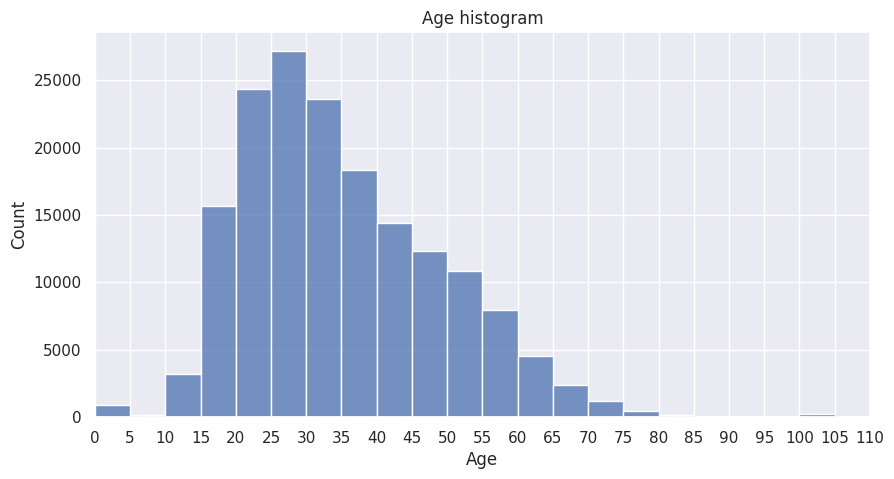

In [14]:
np_age = df_users['Age'].to_numpy()
np_age_num = np_age[~np.isnan(np_age)]
print('Number of NaN ages:', np.count_nonzero(np.isnan(np_age)))
print('Number of ages above 110:', np_age_num[np_age_num > 110].size)

age_x_ticks = [5 * x for x in range(23)]
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(10,5))
sns.histplot(data=df_users, x="Age", ax=ax1, bins=age_x_ticks)
plt.title('Age histogram')
plt.xlim(0, 110)
ax1.set_xticks(age_x_ticks)
plt.show()

We can see that most review are in the form of implicit reviews denoted by zero.

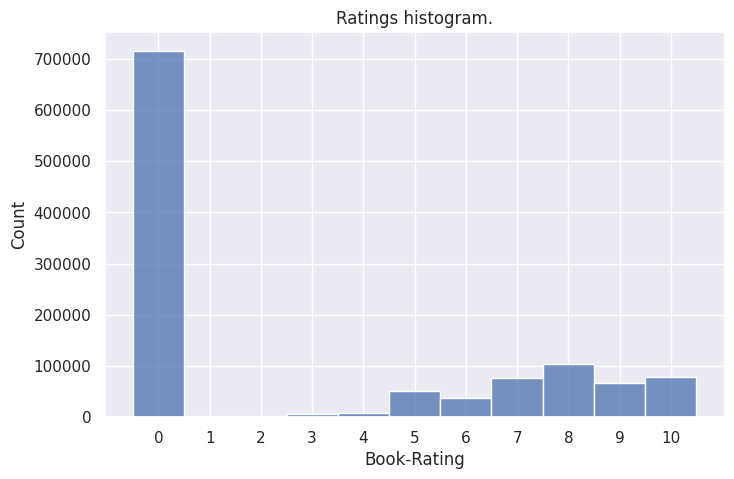

In [15]:
ratings_x_ticks = [x for x in range(11)]
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(8,5))
sns.histplot(data=df_ratings, x="Book-Rating", ax=ax1, discrete=True)
ax1.set_xticks(ratings_x_ticks)
plt.title('Ratings histogram.')
plt.show()

## 2. Preprocessing

Preprocess ISBN and remove duplicate books

In [16]:
np_isbn = df_books['ISBN'].to_numpy(dtype='str')
non_alnum = np.vectorize(lambda x: bool(re.search(r'\W', x)))
result = non_alnum(np_isbn)
strings_with_non_alnum = np_isbn[result]
print('Invalid ISBN in the dataset', strings_with_non_alnum)

Invalid ISBN in the dataset ['0486404242\t' '3518365479<90' '3442248027  3' '0385722206  0']


In [17]:
# Correct invalid ISBN
df_books['ISBN'] = df_books['ISBN'].apply(lambda x: re.sub(r'[\W_]', '', x.strip()))

In [18]:
print('Books dataframe size beofre duplicate removal', len(df_books.index))
# Remove books with duplicate ISBN
df_books.drop_duplicates(subset='ISBN', inplace=True)
print('Books dataframe size after duplicate removal', len(df_books.index))

Books dataframe size beofre duplicate removal 271379
Books dataframe size after duplicate removal 271378


In [19]:
df_books['Book-Author'] = df_books['Book-Author'].fillna("")
df_books['Publisher'] = df_books['Publisher'].fillna("")
df_books['Language'] = df_books['Language'].fillna("")
df_books['Category'] = df_books['Category'].fillna("")

In [20]:
print(np.any(df_books['Summary'].isna()))
print(np.any(df_books['Book-Title'].isna()))
print(np.any(df_books['Book-Author'].isna()))
print(np.any(df_books['Year-Of-Publication'].isna()))
print(np.any(df_books['Publisher'].isna()))
print(np.any(df_books['Language'].isna()))
print(np.any(df_books['Category'].isna()))

False
False
False
False
False
False
False


Add title, author, publication year and publisher to summary.

In [21]:
df_books.loc[df_books['Summary'].str.len() < 2, 'Summary'] = ""
df_books.loc[df_books['Language'].str.len() < 2, 'Language'] = ""
df_books.loc[df_books['Category'].str.len() < 2, 'Category'] = ""

df_books.loc[df_books['Summary'].str.len() > 2, 'BetterSummary'] = df_books.apply(lambda row: f"{row['Book-Title']}, {row['Book-Author']}, {row['Year-Of-Publication']}, {row['Publisher']}, {row['Language']}, {row['Category']}: {row['Summary']}", axis=1)

In [22]:
df_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Summary,Language,Category,BetterSummary
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],"Classical Mythology, Mark P. O. Morford, 2002,..."
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],"Clara Callan, Richard Bruce Wright, 2001, Harp..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,"Here, for the first time in paperback, is an o...",en,['1940-1949'],"Decision in Normandy, Carlo D'Este, 1991, Harp..."


Add one to rating column. To avoid representing implicit review in a same way as no review.

In [23]:
df_ratings.loc[:, 'Book-Rating'] += 1

Merge all tables together so ratings index is the unique identifier

In [24]:
# We perform inner join since we don't want ratings with ISBN that is not in the books table
df_ratings_books = df_ratings.merge(df_books, on="ISBN", how="inner")
print('df_ratings_books number of rows:', df_ratings_books.shape[0])

df_ratings_books_users = df_ratings_books.merge(df_users, on="User-ID", how="inner")
print('df_ratings_books_users number of rows:', df_ratings_books_users.shape[0])

df_ratings_books number of rows: 1031171
df_ratings_books_users number of rows: 1031171


In [25]:
series_books_sumed_rating = df_ratings_books_users.groupby('ISBN')["Book-Rating"].sum()
series_books_sumed_rating.sort_values(ascending=False).head(3)

ISBN
0316666343    7082
0971880107    5053
0385504209    4991
Name: Book-Rating, dtype: int64

In [26]:
series_books_number_of_rating = df_ratings_books_users.groupby('ISBN')["Book-Rating"].count()
series_books_number_of_rating.sort_values(ascending=False).head(3)

ISBN
0971880107    2502
0316666343    1295
0385504209     883
Name: Book-Rating, dtype: int64

In [27]:
series_books_average_rating = series_books_sumed_rating / series_books_number_of_rating

In [28]:
# src: https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), size='medium', color='black')

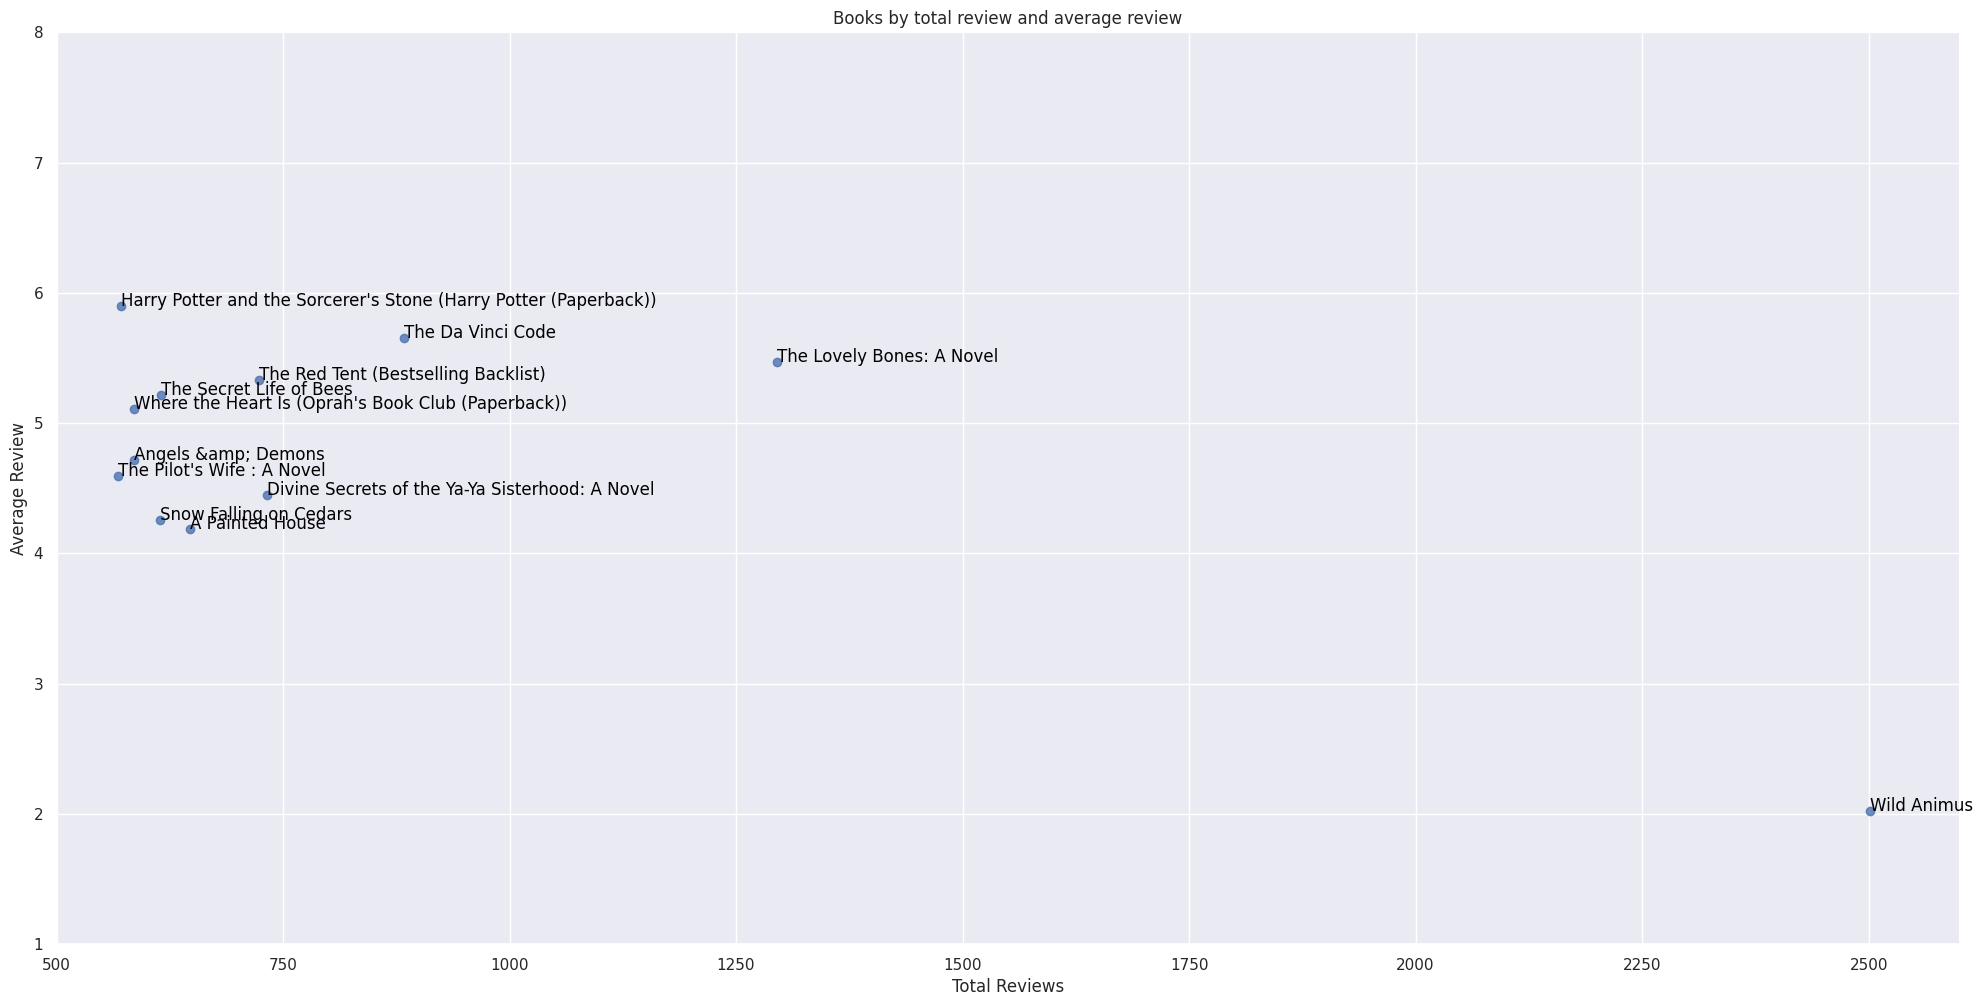

In [29]:
# Add ratings count to the df_ratings_books_users dataframe
df_ratings_books_users['Ratings_count'] = df_ratings_books_users['ISBN'].map(series_books_number_of_rating)
df_ratings_books_users['Average_rating'] = df_ratings_books_users['ISBN'].map(series_books_average_rating)

top_20_books = df_ratings_books_users.drop_duplicates(subset=['ISBN']).sort_values(by='Ratings_count', ascending=False).head(12)

# src: https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
ax = sns.lmplot(x='Ratings_count', # Horizontal axis
           y='Average_rating', # Vertical axis
           data=top_20_books, # Data source
           fit_reg=False, # Don't fix a regression line
           aspect = 2,
           height = 10) # size and dimension

plt.title('Books by total review and average review')
plt.xlabel('Total Reviews')
plt.xlim(500, 2600)
plt.ylim(1, 8)
plt.ylabel('Average Review')

label_point(top_20_books.Ratings_count, top_20_books.Average_rating, top_20_books['Book-Title'], plt.gca())

## 3. Approaches

### User Vectors

As a baseline I will use KNN model on user vectors.

### Transformers

Second model will consists of applying to sentence transformer to individual books and their summaries (this will require extended version of the dataset).

## 4. Training

### User Vectors

We only take books with at least 10 books. If we took all the books the matrix would get extemly large and sparse.

In [30]:
# Books with too few ratings will have very sparse user vectors. Therefore we want to filter them out.
df_filtered_ratings_books_users = df_ratings_books_users[df_ratings_books_users['Ratings_count'] > 10]
# Create user vector
df_user_vectors = df_filtered_ratings_books_users.pivot(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0).astype("uint8")
df_user_vectors.head()

User-ID,8,9,10,14,16,17,19,23,26,32,...,278832,278836,278838,278843,278844,278846,278849,278851,278852,278854
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002251760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002259834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002558122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0006480764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
user_KNN = NearestNeighbors(metric='cosine', n_neighbors=11)

np_mat = df_user_vectors.values

np_mat_norms = np.linalg.norm(np_mat, axis=1)
np_mat_normalized = np_mat / np_mat_norms[:, np.newaxis]

# use sparse matrix to speed up search
user_KNN.fit(csr_matrix(np_mat_normalized))

NearestNeighbors(metric='cosine', n_neighbors=11)

In [102]:
one_isbn = '0385504209' # The Da Vinci Code by Dan Brown
indicies = user_KNN.kneighbors_graph([df_user_vectors.loc[one_isbn]]).indices
isbn_list =  df_user_vectors.iloc[indicies].index.tolist()

In [103]:
df_books[df_books['ISBN'].isin(isbn_list)].head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Summary,Language,Category,BetterSummary
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,,,,NaN
239,0743486226,Angels &amp; Demons,Dan Brown,2003,Atria,http://images.amazon.com/images/P/0743486226.0...,http://images.amazon.com/images/P/0743486226.0...,http://images.amazon.com/images/P/0743486226.0...,,,,NaN
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,"After her &quot;stand-in mother,&quot; a bold ...",en,['Fiction'],"The Secret Life of Bees, Sue Monk Kidd, 2003, ..."
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,,,,NaN
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,Harvard symbologist Robert Langdon and French ...,en,['Fiction'],"The Da Vinci Code, Dan Brown, 2003, Doubleday,..."


In [35]:
def user_recomendation(isbn: str):
    """
    Returns 10 books recomendations based on the user vectors.

    Parameters
    ----------
    isbn : string
        valid isbn
    """
    if isbn not in df_user_vectors.index:
        print(f"{isbn} is not present in our database or is not valid.")
        return

    book_row = df_books[df_books['ISBN'] == isbn]
    book_user_vector = df_user_vectors.loc[isbn]

    similar_indicies = user_KNN.kneighbors_graph([df_user_vectors.loc[isbn]]).indices
    isbn_list = df_user_vectors.iloc[similar_indicies].index.tolist()
    similar_books = df_books[df_books['ISBN'].isin(isbn_list)]

    print(f'Since you liked: {book_row["Book-Title"].iloc[0]}.')
    print('We recomend you take a look a the following books: \n')
    for _, row in similar_books.iterrows():
        print(f'{row["Book-Title"]} by {row["Book-Author"]}')

In [110]:
t = time()
user_recomendation('0385504209')
print(f'\n Search time: {round((time() - t), 2)} seconds')

Since you liked: The Da Vinci Code.
We recomend you take a look a the following books: 

Angels &amp; Demons by Dan Brown
Angels &amp; Demons by Dan Brown
The Secret Life of Bees by Sue Monk Kidd
The Lovely Bones: A Novel by Alice Sebold
The Da Vinci Code by Dan Brown
Nights in Rodanthe by Nicholas Sparks
The Conspiracy Club by JONATHAN KELLERMAN
Street Dreams by Faye Kellerman
Middlesex: A Novel by Jeffrey Eugenides
The Cat Who Talked Turkey by Lilian Jackson Braun
Cyanide Wells by Marcia Muller

 Search time: 0.03 seconds


### Tranformers

In [37]:
df_bert_books = df_books.loc[df_books['Summary'].str.len() > 2]

In [38]:
df_bert_books.reset_index(inplace=True)

In [39]:
df_bert_books.shape

(141960, 13)

In [40]:
model = SentenceTransformer('all-mpnet-base-v2')

def encode_sentence(text):
    return model.encode(text)

In [41]:
to_encode = df_bert_books['BetterSummary']
to_encode.shape

(141960,)

In [42]:
bert_vectors = np.load(f'./bert_books_embeddings_better.npy')

In [43]:
t = time()

print('Started encoding')
# bert_vectors = np.array(to_encode.apply(encode_sentence).tolist())

print(f'\n Time to encode: {round((time() - t), 2)} seconds')

Started encoding

 Time to encode: 0.0 seconds


In [44]:
 # np.save(f'./bert_books_embeddings_better_all', bert_vectors)

In [45]:
BERT_KNN = NearestNeighbors(metric='cosine', n_neighbors=11)

# use sparse matrix to speed up search
BERT_KNN.fit(bert_vectors)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [114]:
bert_one_isbn = '0553573403' # A Game of Thrones
book_index = df_bert_books.loc[df_bert_books['ISBN'] == bert_one_isbn].index[0]
bert_indicies = BERT_KNN.kneighbors_graph([bert_vectors[book_index]]).indices
bert_isbn_list =  df_bert_books.iloc[bert_indicies]['ISBN'].tolist()

In [115]:
df_bert_books[df_bert_books['ISBN'].isin(bert_isbn_list)].head(5)

,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Summary,Language,Category,BetterSummary
88,128,0840734530,"The Oneprince (The Redaemian Chronicles, Book 1)",Bill Hand,1992,Thomas Nelson Inc,http://images.amazon.com/images/P/0840734530.0...,http://images.amazon.com/images/P/0840734530.0...,http://images.amazon.com/images/P/0840734530.0...,This enchanting work of fantasy leads readers ...,en,['Fiction'],"The Oneprince (The Redaemian Chronicles, Book ..."
2791,4713,0553573403,"A Game of Thrones (A Song of Ice and Fire, Boo...",George R.R. Martin,1997,Spectra Books,http://images.amazon.com/images/P/0553573403.0...,http://images.amazon.com/images/P/0553573403.0...,http://images.amazon.com/images/P/0553573403.0...,NOW THE ACCLAIMED HBO SERIES GAME OF THRONESFr...,en,['Fiction'],"A Game of Thrones (A Song of Ice and Fire, Boo..."
2793,4715,055357342X,"A Storm of Swords (A Song of Ice and Fire, Boo...",GEORGE R.R. MARTIN,2003,Spectra,http://images.amazon.com/images/P/055357342X.0...,http://images.amazon.com/images/P/055357342X.0...,http://images.amazon.com/images/P/055357342X.0...,Here is the Third Volume in George R. R. Marti...,en,['Fiction'],"A Storm of Swords (A Song of Ice and Fire, Boo..."
7297,12739,0679879250,"The Subtle Knife (His Dark Materials, Book 2)",Philip Pullman,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679879250.0...,http://images.amazon.com/images/P/0679879250.0...,http://images.amazon.com/images/P/0679879250.0...,Here is the highly anticipated second installm...,en,['Juvenile Fiction'],"The Subtle Knife (His Dark Materials, Book 2),..."
8288,14410,0553381709,"A Storm of Swords : Song of Ice and Fire, Volu...",GEORGE R.R. MARTIN,2002,Spectra,http://images.amazon.com/images/P/0553381709.0...,http://images.amazon.com/images/P/0553381709.0...,http://images.amazon.com/images/P/0553381709.0...,The three surviving contenders for the throne ...,en,['Fiction'],"A Storm of Swords : Song of Ice and Fire, Volu..."


In [107]:
def transformer_recomendation(isbn: str):
    """
    Returns 10 books recomendations based on the user vectors.

    Parameters
    ----------
    isbn : string
        valid isbn
    """
    if not (df_bert_books['ISBN'].eq(isbn)).any():
        print(f"{isbn} is not present in our database or is not valid.")
        return
    book_row = df_bert_books.loc[df_bert_books['ISBN'] == isbn]
    book_index = book_row.index[0]

    similar_indicies = BERT_KNN.kneighbors_graph([bert_vectors[book_index]]).indices
    similar_isbn_list =  df_bert_books.iloc[similar_indicies]['ISBN'].tolist()
    similar_books = df_bert_books[df_bert_books['ISBN'].isin(similar_isbn_list)]
    
    print(f'Since you liked: {book_row["Book-Title"].iloc[0]}.')
    print('We recomend you take a look a the following books: \n')
    for _, row in similar_books.iterrows():
        print(f'{row["Book-Title"]} by {row["Book-Author"]}')

In [123]:
t = time()
transformer_recomendation('0553573403')
print(f'\n Search time: {round((time() - t), 2)} seconds')

Since you liked: A Game of Thrones (A Song of Ice and Fire, Book 1).
We recomend you take a look a the following books: 

The Oneprince (The Redaemian Chronicles, Book 1) by Bill Hand
A Game of Thrones (A Song of Ice and Fire, Book 1) by George R.R. Martin
A Storm of Swords (A Song of Ice and Fire, Book 3) by GEORGE R.R. MARTIN
The Subtle Knife (His Dark Materials, Book 2) by Philip Pullman
A Storm of Swords : Song of Ice and Fire, Volume 3 (A Song of Ice and Fire, Book 3) by GEORGE R.R. MARTIN
Guardians of the West (Book 1 of the Malloreon) by David Eddings
A Storm of Swords (A Song of Ice and Fire, Book 3) by George R. R. Martin
A Clash of Kings (A Song of Ice and Fire, Book 2) by GEORGE R.R. MARTIN
The Sundered Arms (Dungeons &amp; Dragons Novel) by T. H. Lain
Revelations by Douglas E. Winter
A Game of Thrones (A Song of Ice and Fire, Book 1) by George R. R. Martin

 Search time: 0.34 seconds


### Export Data For Application

Bert vectors exports

In [80]:
import json

pine_vecs = []

t = time()
for index in range(len(df_bert_books.index)):
    pine_vecs.append({
      "id": df_bert_books.iloc[index]["ISBN"],
      "metadata": {
        "title": df_bert_books.iloc[index]["Book-Title"],
        "author": df_bert_books.iloc[index]["Book-Author"],
        "image": df_bert_books.iloc[index]["Image-URL-L"]
      },
      "values": bert_vectors[index].tolist()
    })

print('pine_vecs length', len(pine_vecs))
with open(f'./bert_upsert.json', 'w') as f:
    json.dump(pine_vecs, f)
    
print(f'\n Time to export BERT vectors: {round((time() - t), 2)} seconds')

pine_vecs length 141960

 Time to export BERT vectors: 187.99 seconds


In [85]:
df_bert_books_to_index = df_bert_books.sort_values(by='BetterSummary', key=lambda x: x.str.len(), ascending=False)

In [131]:
df_bert_books_to_index["Book-Title"].to_numpy().tolist()[171]

"Storybook Travels : From Eloise's New York to Harry Potter's London, Visits to 30 of the Best-LovedLandmarks in Children's Literature"

In [129]:
df_bert_books_to_index["ISBN"].to_numpy().tolist()[0]

'068483619X'

In [86]:
name_isbn_be = {
    "book_isbn": df_bert_books_to_index["ISBN"].to_numpy().tolist(),
    "book_title": df_bert_books_to_index["Book-Title"].to_numpy().tolist(),
}

with open('./books_index.json', 'w') as f:
    json.dump(name_isbn_be, f)

### Testing

Seach by Title

In [121]:
df_books[df_books['Book-Title'].str.contains('The Fellowship of the Ring')].iloc[0]['ISBN']

'0345339703'

In [130]:
df_bert_books.loc[df_bert_books['ISBN'] == '068483619X']

,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Summary,Language,Category,BetterSummary
60759,108648,068483619X,Sam Spiegel: The Incredible Life and Times of ...,Natasha Fraser-Cavassoni,2003,Simon &amp; Schuster,http://images.amazon.com/images/P/068483619X.0...,http://images.amazon.com/images/P/068483619X.0...,http://images.amazon.com/images/P/068483619X.0...,The first-ever complete biography of Hollywood...,en,['Biography & Autobiography'],Sam Spiegel: The Incredible Life and Times of ...


In [52]:
# Getting 403 when trying to display images in the notebook
def display_images(image_urls):
    images = []
    for url in image_urls:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(io.BytesIO(response.content)).resize((150, 150))
            images.append(img)

    fig, axs = plt.subplots(1, 8, figsize=(16, 4))
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis('off')

    plt.show()